In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import time
import pickle
import psutil

In [336]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
prod_dict={}
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    prod_dict[pid] = pname

In [337]:
prods = products[1:]

In [338]:
"""#read transactions
import pickle
orders=pickle.load(open("order_products.pickle", "rb"))

#check products on order 2:
for prod in orders[2]: print(products[prod])"""

'#read transactions\nimport pickle\norders=pickle.load(open("order_products.pickle", "rb"))\n\n#check products on order 2:\nfor prod in orders[2]: print(products[prod])'

In [339]:
# Load the transaction dataset from a pickle file
with open("order_products.pickle", "rb") as f:
    orders = pickle.load(f)

# Convert the transaction data into a list of lists
orders_list = [list(order) for order in orders.values()]

In [340]:
# Encode the transaction data as a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(orders_list, sparse=True)

In [341]:
df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

In [342]:
df.columns = [prod_dict[str(key)] for key in df.columns]

In [343]:
from sys import getsizeof

print(f"Size of orders {getsizeof(orders)/1024/1024} MB")
print(f"Size of orders_list {getsizeof(orders_list)/1024/1024} MB")
print(f"Size of te_ary {getsizeof(te_ary)/1024/1024} MB")
print(f"Size of product_dict {getsizeof(prod_dict)/1024/1024} MB")
print(f"Size of products {getsizeof(products)/1024/1024} MB")

Size of orders 160.00009155273438 MB
Size of orders_list 26.16533660888672 MB
Size of te_ary 4.57763671875e-05 MB
Size of product_dict 2.500091552734375 MB
Size of products 0.379150390625 MB


In [344]:
orders = None
orders_list = None


In [345]:
print(f"Size of orders {round(getsizeof(orders)/1024/1024, 4)} MB")
print(f"Size of orders_list {round(getsizeof(orders_list)/1024/1024, 4)} MB")

Size of orders 0.0 MB
Size of orders_list 0.0 MB


In [346]:
#Here is the main search for the minimum support, took hours to fully run. Don't run again.

min_support = 0.0
increment = 0.0
max_time = 60*60*2 # 2 hours in seconds
starting_support = [0.1, 0.01, 0.001, 0.0001, 0.00001]
cont = True

#Creae and open a file to write the results
def find_min_support():
    with open("min_support2.txt", "w") as f:
        for i in range(len(starting_support)):
            if round(min_support, 6) == 0.0:
                min_support = starting_support[i]
                increment = starting_support[i]/10
                cont = True
            else:
                continue
            while cont == True:
                start_time = time.time()
                frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, low_memory=True)
                #Save the frequent itemsets to a csv file
                frequent_itemsets.to_csv('frequent_itemsets3.csv', index=False)
                end_time = time.time()
                memory_usage = frequent_itemsets.memory_usage(deep=True).sum()
                total_memory = psutil.virtual_memory().available
                elapsed_time = end_time - start_time

                #Record the results and save to file
                f.write('Minimum support: {:.3f}, Time: {:.3f} s, FI Mem usage: {:.3f}MB, Total Mem usage: {:.3f}MB\n'.format(round(min_support, 6), elapsed_time, memory_usage/1024/1024, total_memory/1024/1024))
                f.write(f"{round(min_support, 6)}\n")
                print('Minimum support: {:.3f}, Time: {:.3f} s, FI Mem usage: {:.3f}MB, Total Mem usage: {:.3f}MB'.format(round(min_support, 6), elapsed_time, memory_usage/1024/1024, total_memory/1024/1024))
                
                min_support -= increment
                if round(min_support, 6) == 0.0:
                    cont = False
                
                print(f"Continue: {cont}")
                if elapsed_time > max_time:
                    print(f"Minimum support: {round(min_support, 6)} exceeded time limit")
                    break

#find_min_support()

In [347]:
with open("min_support.txt", "r") as f:    
    #Store the lines in a list
    lines = f.readlines()
    #Get the last line without \n
    min_sup = float(lines[-1].rstrip())
    print(f"Minimum support: {min_sup}")
    
    min_sups = [float(lines[i].split()[2].replace(',', '')) for i in range(0, len(lines), 2)]

    times = [float(lines[i].split()[4].replace(',', '')) for i in range(0, len(lines), 2)]

    mem_usage = [float(lines[i].split()[9].replace('MB,', '')) for i in range(0, len(lines), 2)]

Minimum support: 0.0006


In [348]:
import plotly.graph_objects as go

fig = go.Figure()

# Add the time and memory usage data to the first and second y-axis
fig.add_trace(go.Scatter(x=min_sups, y=times, name='Time'))
fig.add_trace(go.Scatter(x=min_sups, y=mem_usage, name='Memory Usage', yaxis='y2'))

# Set the layout for the figure
fig.update_layout(
    title='Time and Memory Usage vs. Minimum Support', xaxis_title='Minimum Support', yaxis=dict(title='Time (s)'),
    yaxis2=dict(title='Memory Usage (MB)', overlaying='y', side='right'))

# Reverse the x-axis
fig.update_xaxes(autorange='reversed')
fig.update_layout(template='ggplot2')

fig.show()


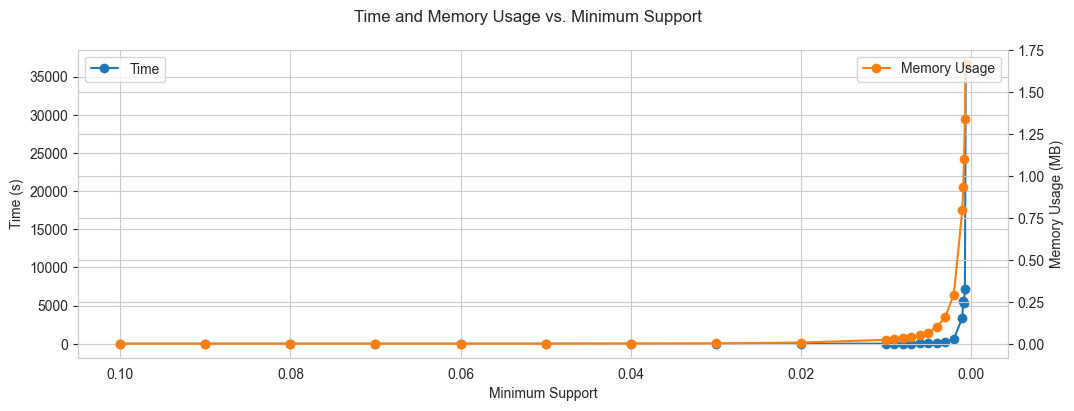

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new figure
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 4)

# Add the time data to the first y-axis
ax1.plot(min_sups, times, label='Time', color='tab:blue', marker='o')
ax1.set_xlabel('Minimum Support')
ax1.set_ylabel('Time (s)')

# Create a second y-axis and add the memory usage data
ax2 = ax1.twinx()
ax2.plot(min_sups, mem_usage, label='Memory Usage', color='tab:orange', marker='o')
ax2.set_ylabel('Memory Usage (MB)')

# Set the layout for the figure
fig.suptitle('Time and Memory Usage vs. Minimum Support')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
sns.set_style('whitegrid')

# Reverse the x-axis
ax1.invert_xaxis()
plt.show()


In [350]:
import ast
fi = pd.read_csv('frequent_itemsets3.csv')

#Convert itemsets from strings to back to frozenset
for i in range(0, len(fi["itemsets"])):
    # Remove the 'frozenset()' part from the string
    line = fi["itemsets"][i].replace("frozenset(", "").replace(')', '')
    # Convert the remaining string to a frozenset using ast.literal_eval
    fi["itemsets"][i] = frozenset(ast.literal_eval(line))

/var/folders/hw/n2l_r7sj3fj2mg88w0q6fpcc0000gn/T/ipykernel_58473/2110204280.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [351]:
fi['length'] = fi['itemsets'].apply(lambda x: len(x))
fi.head()

,support,itemsets,length
0,0.000800,(Sparkling Orange Juice & Prickly Pear Beverage),1
1,0.000674,(Salted Caramel Lean Protein & Fiber Bar),1
2,0.002033,(Peanut Butter Cereal),1
3,0.005727,(European Cucumber),1
4,0.000718,(Vegetarian Grain Meat Sausages Italian - 4 CT),1


In [352]:
min_support_vaue = min(fi["support"])
print(f"Minimum support value: {min_support_vaue}")

Minimum support value: 0.0006000235156961


In [366]:
rules = association_rules(fi, metric="support", min_threshold=0.0006)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(European Cucumber),(Bag of Organic Bananas),0.005727,0.118030,0.000699,0.121979,1.033462,0.000023,1.004498
1,(Bag of Organic Bananas),(European Cucumber),0.118030,0.005727,0.000699,0.005919,1.033462,0.000023,1.000193
2,(European Cucumber),(Organic Strawberries),0.005727,0.082331,0.000848,0.148048,1.798205,0.000376,1.077137
3,(Organic Strawberries),(European Cucumber),0.082331,0.005727,0.000848,0.010299,1.798205,0.000376,1.004619
4,(European Cucumber),(Organic Baby Spinach),0.005727,0.075251,0.000642,0.112095,1.489620,0.000211,1.041496
5,(Organic Baby Spinach),(European Cucumber),0.075251,0.005727,0.000642,0.008532,1.489620,0.000211,1.002828
6,(European Cucumber),(Banana),0.005727,0.146993,0.001456,0.254168,1.729114,0.000614,1.143699
7,(Banana),(European Cucumber),0.146993,0.005727,0.001456,0.009903,1.729114,0.000614,1.004218
8,(European Cucumber),(Limes),0.005727,0.043743,0.000673,0.117471,2.685513,0.000422,1.083543
9,(Limes),(European Cucumber),0.043743,0.005727,0.000673,0.015381,2.685513,0.000422,1.009804


In [354]:
len(rules)

14050

In [355]:
sorted_rules = rules.sort_values(by=['lift'], ascending=False)
relevant_rules = sorted_rules[sorted_rules['lift'] >= 0.8]
sorted_rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3196,(Almond Milk Blueberry Yogurt),(Almond Milk Peach Yogurt),0.001467,0.001464,0.000703,0.479220,327.306327,0.000701,1.917384
3197,(Almond Milk Peach Yogurt),(Almond Milk Blueberry Yogurt),0.001464,0.001467,0.000703,0.480136,327.306327,0.000701,1.920758
3194,(Almond Milk Blueberry Yogurt),(Almond Milk Strawberry Yogurt),0.001467,0.001779,0.000840,0.572943,322.073808,0.000838,2.337443
3195,(Almond Milk Strawberry Yogurt),(Almond Milk Blueberry Yogurt),0.001779,0.001467,0.000840,0.472460,322.073808,0.000838,1.892811
7983,(Almond Milk Peach Yogurt),(Almond Milk Strawberry Yogurt),0.001464,0.001779,0.000770,0.526238,295.818730,0.000768,2.107007


In [356]:
import pandas as pd
from collections import Counter

# Flatten the frequent itemsets into a list of individual items
items = [item for itemset in fi['itemsets'] for item in itemset]

# Use Counter to count the occurrences of each item
item_counts = Counter(items)

# Find the item that appears most frequently
most_common_item, count = item_counts.most_common(1)[0]

print(f"The product that appears most in all frequent itemsets is {most_common_item} with a count of {count}.")


The product that appears most in all frequent itemsets is Banana with a count of 781.


In [357]:
su = fi.support.unique()#all unique support count
#Dictionay storing itemset with same support count key
fredic = {}
for i in range(len(su)):
    inset = list(fi.loc[fi.support ==su[i]]['itemsets'])
    fredic[su[i]] = inset

#Dictionay storing itemset with  support count <= key
fredic2 = {}
for i in range(len(su)):
    inset2 = list(fi.loc[fi.support<=su[i]]['itemsets']) #returns list of itemsets where support is <= support count in su[:]
    fredic2[su[i]] = inset2

#Find Closed frequent itemset
closed = []
#for index, row in fi.iterrows():
for index, row in fi.iterrows():
    isclose = True
    cli = row['itemsets']
    cls = row['support']
    checkset = fredic[cls]
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        closed.append(row['itemsets'])
    

In [358]:
#fredic[SupportCount] = [itemsets with same support]
#fredic2[SupportCount] = [itemsets with <= SupportCount]

In [375]:
#Find Max frequent itemset
maximal = []
for index, row in fi.iterrows():
    isclose = True
    cli = row['itemsets']
    cls = row['support']
    checkset = fredic2[cls]
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        maximal.append(row['itemsets'])

In [360]:
print(f"Number of closed itemsets: {len(closed)}")
print(f"Number of maximal itemsets: {len(maximal)}")

Number of closed itemsets: 8099
Number of maximal itemsets: 6870


In [361]:
fi['maximal'] = fi['itemsets'].apply(lambda x: x in maximal)
fi['closed'] = fi['itemsets'].apply(lambda x: x in closed)
fi.head(8)

,support,itemsets,length,maximal,closed
0,0.000800,(Sparkling Orange Juice & Prickly Pear Beverage),1,True,True
1,0.000674,(Salted Caramel Lean Protein & Fiber Bar),1,True,True
2,0.002033,(Peanut Butter Cereal),1,True,True
3,0.005727,(European Cucumber),1,False,True
4,0.000718,(Vegetarian Grain Meat Sausages Italian - 4 CT),1,True,True
5,0.001115,(Wild Albacore Tuna No Salt Added),1,True,True
6,0.000867,(Organic Rice Vinegar),1,True,True
7,0.001356,(English Muffins),1,True,True


In [376]:
#get a subset of dataframe fi with maximal itemsets
nonmaximal = fi[~fi['itemsets'].isin(maximal)]

In [362]:
#get a subset of dataframe fi with maximal itemsets
maximal = fi[fi['itemsets'].isin(maximal)]
maximal

,support,itemsets,length,maximal,closed
0,0.000800,(Sparkling Orange Juice & Prickly Pear Beverage),1,True,True
1,0.000674,(Salted Caramel Lean Protein & Fiber Bar),1,True,True
2,0.002033,(Peanut Butter Cereal),1,True,True
4,0.000718,(Vegetarian Grain Meat Sausages Italian - 4 CT),1,True,True
5,0.001115,(Wild Albacore Tuna No Salt Added),1,True,True
...,...,...,...,...,...
8094,0.000624,"(Bag of Organic Bananas, Organic Hass Avocado,...",4,True,True
8095,0.000725,"(Organic Raspberries, Bag of Organic Bananas, ...",4,True,True
8096,0.000618,"(Banana, Organic Avocado, Organic Baby Spinach...",4,True,True
8097,0.000714,"(Banana, Organic Avocado, Organic Baby Spinach...",4,True,True


Get a subset of the rules that are part of the Maximal itemsets - still working on this

In [363]:
maximal_itemsets = list(maximal['itemsets'])


In [364]:
ants = list(set(rules["antecedents"]))
cons = list(set(rules["consequents"]))

In [365]:
#find out if any of the maximal itemsets are in the antecedents or consequents of the rules
maximal_antecedents = []
maximal_consequents = []
for i in range(len(maximal_itemsets)):
    if(maximal_itemsets[i] in ants):
        maximal_antecedents.append(maximal_itemsets[i])
    if(maximal_itemsets[i] in cons):
        maximal_consequents.append(maximal_itemsets[i])

print(f"Number of maximal antecedents: {len(maximal_antecedents)}")
print(f"Number of maximal consequents: {len(maximal_consequents)}")

Number of maximal antecedents: 0
Number of maximal consequents: 0


In [368]:
len(ants)

1229

In [369]:
len(cons)

1229

In [377]:
nonmaximal

,support,itemsets,length,maximal,closed
3,0.005727,(European Cucumber),1,False,True
14,0.011133,(Soda),1,False,True
19,0.007434,(Cantaloupe),1,False,True
27,0.004809,(Organic Whole Grassmilk Milk),1,False,True
29,0.002436,(Cheerios Cereal),1,False,True
...,...,...,...,...,...
7900,0.001821,"(Organic Avocado, Organic Baby Spinach, Large ...",3,False,True
7961,0.002409,"(Banana, Limes, Large Lemon)",3,False,True
7962,0.002261,"(Banana, Organic Avocado, Limes)",3,False,True
8033,0.002620,"(Banana, Organic Avocado, Large Lemon)",3,False,True


In [384]:
nonmaximal["itemsets"][14] in cons

True

Other approach for finding maximal itemsets and rules:

In [211]:
from mlxtend.frequent_patterns import apriori, association_rules
import itertools

min_confidence= 0.3
min_lift = 1.0
# Generate frequent itemsets
frequent_itemsets = fi

# Generate maximal itemsets
maximal_itemsets = frequent_itemsets.copy()
for i, itemset in frequent_itemsets.iterrows():
    if not any(frequent_itemsets['itemsets'].apply(lambda x: x.issuperset(itemset['itemsets']) and x != itemset['itemsets'])):
        continue
    maximal_itemsets = maximal_itemsets.drop(i)



In [212]:
len(maximal_itemsets)

6870

In [229]:
# Generate association rules for each maximal itemset
maximal_rules = []
for i, itemset in maximal_itemsets.iterrows():
    itemset_support = itemset['support']
    itemset_items = itemset['itemsets']
    itemset_size = len(itemset_items)
    
    # Generate all possible subsets of the itemset
    subsets = [frozenset(x) for x in set(itertools.combinations(itemset_items, itemset_size-1))]
    
        # Generate association rules for each subset
    if len(subsets) > 1:
        for subset in subsets:
            antecedent_support = fi.loc[fi['itemsets']==subset, 'support'].values[0] #
            consequent_support = itemset_support
            rule_support = itemset_support
            confidence = rule_support / antecedent_support
            lift = confidence / (consequent_support / len(orders_list))
            
            # Add rule to the list if it meets the confidence and lift thresholds
            if confidence >= min_confidence and lift >= min_lift:
                maximal_rules.append({'antecedent': subset, 'consequent': itemset_items-subset, 'support': rule_support, 'confidence': confidence, 'lift': lift})


In [228]:
max_rules = pd.DataFrame(maximal_rules, columns=['antecedent', 'consequent', 'support', 'confidence', 'lift'])
max_rules

,antecedent,consequent,support,confidence,lift
0,(Zero Calorie Cola),(Soda),0.001235,0.463893,1.207690e+09
1,(Garnet Sweet Potato (Yam),(Banana),0.000656,0.313140,1.534583e+09
2,(Mango Chunks),(Banana),0.001745,0.316911,5.839547e+08
3,(Cherry Pomegranate Greek Yogurt),(Banana),0.000666,0.312336,1.507060e+09
4,(Organic Greek Lowfat Yogurt With Blueberries),(Organic Greek Lowfat Yogurt With Strawberries),0.000609,0.410176,2.164032e+09
...,...,...,...,...,...
448,"(Organic Avocado, Organic Baby Spinach, Organi...",(Banana),0.000618,0.382602,1.989110e+09
449,"(Organic Avocado, Organic Baby Spinach, Large ...",(Banana),0.000714,0.392277,1.765832e+09
450,"(Banana, Organic Baby Spinach, Large Lemon)",(Organic Avocado),0.000714,0.317083,1.427346e+09
451,"(Organic Avocado, Banana, Limes)",(Large Lemon),0.000706,0.312147,1.421848e+09
